<a href="https://colab.research.google.com/github/vu-topics-in-big-data-2021/examples/blob/main/example-ml/decisiontrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://cdn.vanderbilt.edu/vu-www4/brandbar/svg/Optimized/vanderbilt.svg)



# Decision Tree Classification

## About this Lesson
In this lesson, we will learn about and implement a decision tree classifier using scikit-learn.

In [11]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

## Importing Data

We will use a drug test dataset taken from [Kaggle](https://www.kaggle.com/gangliu/drugsets). In this set, the data is collected from a group of patients, all of whom have the same condition. During the course of treatment, each patient responded well to one of five different medications, which is what is recorded in the data.

In [12]:
url = 'https://raw.githubusercontent.com/vu-topics-in-big-data-2021/examples/main/example-ml/datasets/classification/drug200.csv'
data = pd.read_csv(url)
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


## Preprocessing Data

Before processing the data, we need to extract what values are the features and what values are the targets. In this dataset, we are trying to predict which medication will be effective for a patient based on their other attributes. So, our target will be *Drug* and the features will be *Age, Sex, BP, Cholesterol,* and *NA_to_K*. 

In [13]:
X = data[["Age", "Sex", "BP", "Cholesterol", "Na_to_K"]]
y = data["Drug"]

When working with data analysis, most algorithms expect the data to be numeric. However, this is clearly an issue for data which is categorical, such has sex and drug choice. So, before we pass these values into the algorithm, we must convert them to a numeric representation. Since categorical data has only a finite number of possible values, we can encode these values as numbers. For example, if Sex can have value $M$ or $F$, we can encode $M=0$ and $F=1$. Scikit-learn has a function which can automate this process for us.

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
X = pd.DataFrame()

le_sex = LabelEncoder()
le_sex.fit(['M', 'F'])
X["Sex"] = le_sex.transform(data["Sex"])

le_BP = LabelEncoder()
le_BP.fit(['LOW', 'NORMAL', 'HIGH'])
X["BP"] = le_BP.transform(data["BP"])

le_chol = LabelEncoder()
le_chol.fit(['NORMAL', 'HIGH'])
X["Cholesterol"] = le_chol.transform(data["Cholesterol"])

# We do not encode Age or Na_to_K because they are already numeric
X["Age"] = data["Age"]
X["Na_to_K"] = data["Na_to_K"]

X.head()

,Sex,BP,Cholesterol,Age,Na_to_K
0,0,0,0,23,25.355
1,1,1,0,47,13.093
2,1,1,0,47,10.114
3,0,2,0,28,7.798
4,0,1,0,61,18.043


Sometimes there are numerical values attributes which are really more informative when they are binned into categories. For example, when we are looking at age in this data, we might not care about a person's specific age but rather care about to what age bracket they belong. To demonstate this, we can build a histogram of the age data and see that the patients can be distributed fairly evenly into four brackets.

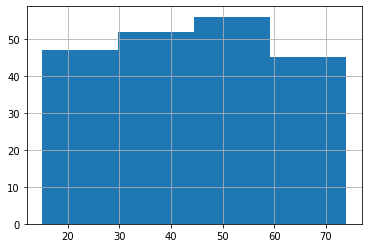

In [16]:
X['Age'].hist(bins=4)

Sometimes this binned representation is more adventageous than keeping the variables modeled as continuous attributes. However, this kind of binning happens internally for decision tree classifiers so we do not need to encode the data in this manner for this case.

Now that the data is preprocessed, we are ready to move onto using the algorithms.

## Creating a Train and Test Split

One of the most important aspects of creating models is to be able to evaluate how well those models work. We have previously discussed how creating a train-test split of the data allows us to test the model on different data than it was trained on, thereby giving an accurate representation of the accuracy of the model. However, this approach also has some limitations. 

Depending on how the train and test data were sampled, the accuracy of the model could be significantly higher or lower than the real accuracy. To help combat this, we can employ a method known as k-fold cross validation. In cross validation, the data is divided into $k$ distinct groups (typically randomly). Then, one of these groups is held out for testing and the rest of the groups are used as training data. This process is repeated until all of the groups are held out once and the results from each test are averaged. This allows us to get an even more accurate representation of how the model performs on unseen data and the performance if it were to be trained on the entire dataset.

We can use the scikit-learn library to run the model with k-fold cross validation. For this example, we will use $k=10$, which uses 90% of the data for training on the given iteration.

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
k_crossVal = 10

## Decision Tree Classifier

Now we are finally ready to create the model. We will use the decision tree classifier from scikit-learn to create the model using the features and the target that we defined above. Once again, we will fix the random seed so that everyone in the class gets the same results.

In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [20]:
clf = DecisionTreeClassifier(random_state=1)

When we execute this code, it instantiates the decision tree classifier with all of the default parameters. Many of these parameters are important for many different applications, but the main one to pay attention to here is the *criterion*. This is the function which the decision tree uses to decide when and where to split the data. By default scikit-learn uses the *gini* function, which is a good choice for many cases. However, there are several other choices for criterion functions which are useful in a variety of situations. For now, we'll stick with the gini function, but you may want to try out other functions on your own to compare their performance.

Now that we have instantiated our decision tree classifier, we want to use k-fold cross validation to train and evaluate how well it is able to predict the drug choice. For classification tasks, there are many different ways to measure the performance of a model, but one of the most common is the accuracy score.

Accuracy measures the percentage of test data that was correctly labeled. The closer the accuracy is to 1, the better the results. In this sense, it is very easy to interpret. For accuracy to be a good measure of performance, the number of points which contain each label must be approximately equal. However in this dataset, this is the case and there are approximately equal numbers of each class. So, we will use accuracy for measurement.

Since we are using cross validation, we get $k$ accuracy scores, which we can average to get the general accuracy. We can also build a 95% confidence interval around this accuracy score for the true accuracy of the model.

In [21]:
from sklearn import metrics

In [22]:
scores = cross_val_score(clf, X, y, cv=k_crossVal)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.99 (+/- 0.04)


As we can see, the decision tree was extremely accurate when evaluated on the testing data.

## Visualizing the Classifier

One of the biggest assets of the decision tree classifier  is its simplicity and interpretability. We can actually plot the decision tree to see just how it is making its decisions. Lets plot the tree that we generated above.

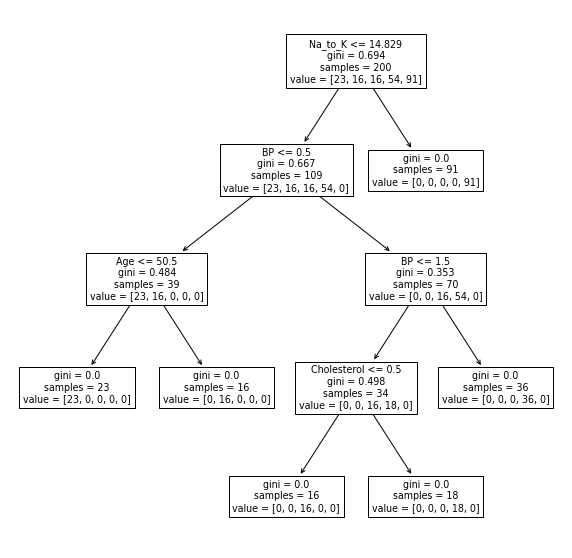

In [23]:
clf.fit(X,y)
feature_labels = ["Sex", "BP", "Cholesterol", "Age", "Na_to_K"]

plt.figure(figsize=(10,10))
plot_tree(clf, feature_names=feature_labels)
plt.show()

This plot shows the structure of the decision tree, including the decision criteria, gini value, and distribution of samples at each node. Looking at this tree stucture can reveal some more information to us about how the classifier is making its decision. For example, none of the nodes use sex as a criterion, meaning it does not matter for the decision of which drug to use. Being able to plot and interpret the decision tree is one of the reasons that it is so powerful as a classifier.

## Tree Pruning

When we construct decision trees, by default the algorithm continues deepening the tree (creating more layers) until the data is completely pure (i.e. only one class in each leaf node). This may seem like the right thing to do at first, but in reality it leads to overfitting. Overfitting is the phenomena where a machine learning model is so specifically tuned to the data on which it was trained that the training does not generalize to new examples well. When we think about overfitting, we generally think about the Occam'z razor principle. A less complex model is favored over a more complex model.

For decision trees, we avoid overfitting by a process known as pruning. Pruning takes the fully trained tree and remove certain branches to reduce the model complexity. Pruning can be done in two ways: pre-pruning and post-pruning. Pre-pruning happens during the training phase. It stops the tree construction process once a certain depth is reached. Post-pruning instead grows the tree fully and then removes branches which lead to the least information gain.

To demonstrate the effect of pruning, we will look at the Iris dataset, which is a famous dataset which classifies flowers based on their physical attributes.

In [24]:
from sklearn.datasets import load_iris

In [25]:
iris_data = load_iris()

X_iris = iris_data.data
y_iris = iris_data.target

target_names = iris_data.target_names
feature_names = iris_data.feature_names

We can build the entire decision tree and plot it to view its complexity at full growth.

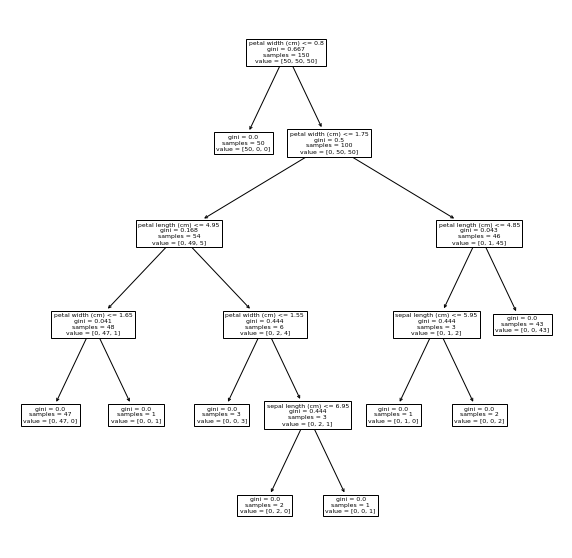

Accuracy: 0.95 (+/- 0.09)


In [26]:
clf_iris = DecisionTreeClassifier(random_state=1)
scores = cross_val_score(clf_iris, X_iris, y_iris, cv=k_crossVal)
clf_iris.fit(X_iris,y_iris)

plt.figure(figsize=(10,10))
plot_tree(clf_iris, feature_names=feature_names)
plt.show()
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

As you can see, the tree has very high accuracy but it is also very complex for just four features. In order to determine the best way to prune this tree, we plot what is known as a bias-variance tradeoff curve. This curve plots the accuracy of the model against the model's complexity to find the trade off point. To build the curve for the iris data, we will use pre-pruning and construct a tree with each depth from 1 until the depth of the complete tree, 6. For each constructed tree, we will use 10-fold cross validation to score the model.

In [27]:
pruning_scores = []
depths = list(range(1,7))
for depth in depths:
    clf_iris = DecisionTreeClassifier(max_depth=depth, random_state=1)
    
    scores = cross_val_score(clf_iris, X_iris, y_iris, cv=k_crossVal)
    pruning_scores.append(scores.mean())

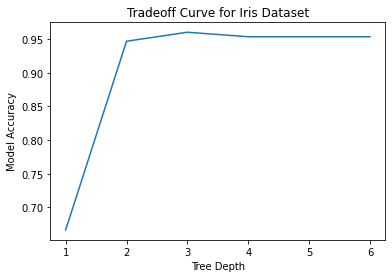

In [28]:
plt.plot(depths, pruning_scores)
plt.xlabel("Tree Depth")
plt.ylabel("Model Accuracy")
plt.title("Tradeoff Curve for Iris Dataset")
plt.show()

When we evaluate the tradeoff curve, we look for the "knee" of the curve, which is the point with the highest concavity. In this case, the knee occurs at depth 2, indicating that pruning to a depth of 2 produces the optimal tree which is accurate but not overfit. We can then plot the decision tree pruned to this depth.

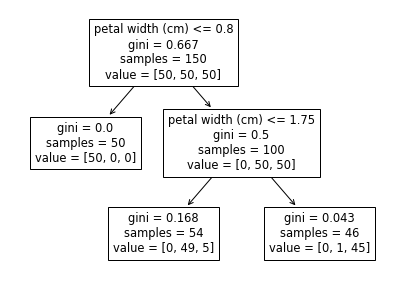

Accuracy: 0.95 (+/- 0.10)


In [29]:
clf_iris = DecisionTreeClassifier(max_depth=2, random_state=1)
scores = cross_val_score(clf_iris, X_iris, y_iris, cv=k_crossVal)
clf_iris.fit(X_iris,y_iris)

plt.figure(figsize=(7,5))
plot_tree(clf_iris, feature_names=feature_names)
plt.show()

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

We can see that this produces a very simple and interpretable tree with accuracy that is nearly as high as the complete tree. In addition, this smaller tree should generalize significantly better to new training examples.